In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import pandas as pd
from pandas.api.types import is_integer_dtype, is_float_dtype

load_dotenv()
os.chdir(os.getenv('BASE_PATH'))


In [2]:
df = pd.read_csv('data/raw/retail_store_inventory.csv')
df.drop(columns=['Date', 'Store ID', 'Product ID'], axis=1, inplace=True)

In [3]:
df = df.rename(columns={'Inventory Level': 'Inventory',
                        'Units Sold': 'Sales',
                        'Units Ordered': 'Orders',
                        'Demand Forecast': 'Demand',
                        'Weather Condition': 'Weather',
                        'Holiday/Promotion': 'Promotion',
                        'Competitor Pricing': 'Competitor Price'})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          73100 non-null  object 
 1   Region            73100 non-null  object 
 2   Inventory         73100 non-null  int64  
 3   Sales             73100 non-null  int64  
 4   Orders            73100 non-null  int64  
 5   Demand            73100 non-null  float64
 6   Price             73100 non-null  float64
 7   Discount          73100 non-null  int64  
 8   Weather           73100 non-null  object 
 9   Promotion         73100 non-null  int64  
 10  Competitor Price  73100 non-null  float64
 11  Seasonality       73100 non-null  object 
dtypes: float64(3), int64(5), object(4)
memory usage: 6.7+ MB


In [5]:
def downcast_ints(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    int_cols = [c for c in df.columns if is_integer_dtype(df[c])]
    for c in int_cols:
        s = df[c]
        if s.min() >= 0:
            df[c] = pd.to_numeric(s, downcast="unsigned")  # -> uint8/16/32/64
        else:
            df[c] = pd.to_numeric(s, downcast="integer")   # -> int8/16/32/64
    return df

def optimize_df(df: pd.DataFrame) -> pd.DataFrame:
    start = df.memory_usage(deep=True).sum()
    out = df.copy()

    # 1) Downcast integers
    out = downcast_ints(out)

    # 2) Downcast floats
    float_cols = [c for c in out.columns if is_float_dtype(out[c])]
    out[float_cols] = out[float_cols].apply(pd.to_numeric, downcast="float")  # -> float32

    end = out.memory_usage(deep=True).sum()
    print(f"Memory: {start/1024**2:.2f} MB → {end/1024**2:.2f} MB "
          f"({(1 - end/start)*100:.1f}% reduction)")
    return out

df_opt = optimize_df(df)
df_opt.info()


Memory: 22.03 MB → 18.89 MB (14.2% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          73100 non-null  object 
 1   Region            73100 non-null  object 
 2   Inventory         73100 non-null  uint16 
 3   Sales             73100 non-null  uint16 
 4   Orders            73100 non-null  uint8  
 5   Demand            73100 non-null  float32
 6   Price             73100 non-null  float32
 7   Discount          73100 non-null  uint8  
 8   Weather           73100 non-null  object 
 9   Promotion         73100 non-null  uint8  
 10  Competitor Price  73100 non-null  float32
 11  Seasonality       73100 non-null  object 
dtypes: float32(3), object(4), uint16(2), uint8(3)
memory usage: 3.6+ MB


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          73100 non-null  object 
 1   Region            73100 non-null  object 
 2   Inventory         73100 non-null  int64  
 3   Sales             73100 non-null  int64  
 4   Orders            73100 non-null  int64  
 5   Demand            73100 non-null  float64
 6   Price             73100 non-null  float64
 7   Discount          73100 non-null  int64  
 8   Weather           73100 non-null  object 
 9   Promotion         73100 non-null  int64  
 10  Competitor Price  73100 non-null  float64
 11  Seasonality       73100 non-null  object 
dtypes: float64(3), int64(5), object(4)
memory usage: 6.7+ MB


In [7]:
x = df_opt.drop(columns=['Demand'])
y = df_opt['Demand']

In [8]:
from sklearn.preprocessing import LabelEncoder

def label_encode(x):
  label_encoder = LabelEncoder()
  x['Category'] = label_encoder.fit_transform(x['Category'])
  x['Region'] = label_encoder.fit_transform(x['Region'])
  x['Weather'] = label_encoder.fit_transform(x['Weather'])
  x['Seasonality'] = label_encoder.fit_transform(x['Seasonality'])
  x['Promotion'] = label_encoder.fit_transform(x['Promotion'])
  return x

x = label_encode(x)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)

In [11]:
class HParamMetrics:

  def __init__(self, est):
    self.est = est
    self.train_rn = None
    self.y_pred = None
    self.test_r2 = None
    self.mse = None
    self.rmse = None
    self.mae = None

In [12]:
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_model(model, x_train, y_train, x_test, y_test, HPM):
  # calculate metrics
  HPM.train_r2 = model.score(x_train, y_train)
  HPM.y_pred = model.predict(x_test)
  HPM.test_r2 = r2_score(y_test, HPM.y_pred)
  HPM.mse = mean_squared_error(y_test, HPM.y_pred)
  HPM.rmse = np.sqrt(HPM.mse)
  HPM.mae = mean_absolute_error(y_test, HPM.y_pred)

  #prepare the table data
  metrics = [
    ["Training R^2 Score", f"{HPM.train_r2:.4f}"],
    ["Testing R^2 Score", f"{HPM.test_r2:.4f}"],
    ["Mean Squared Error (MSE)", f"{HPM.mse:.2f}"],
    ["Root Mean Squared Error (RMSE)", f"{HPM.rmse:.2f}"],
    ["Mean Absolute Error (MAE)", f"{HPM.mae:.2f}"],
  ]

  # Print the table
  print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid"))

In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

initial_HPM = HParamMetrics(lr.fit(x_train, y_train))

In [14]:
evaluate_model(lr, x_train, y_train, x_test, y_test, initial_HPM)

+--------------------------------+---------+
| Metric                         |   Value |
+================================+=========+
| Training R^2 Score             |  0.9937 |
+--------------------------------+---------+
| Testing R^2 Score              |  0.9937 |
+--------------------------------+---------+
| Mean Squared Error (MSE)       | 74.37   |
+--------------------------------+---------+
| Root Mean Squared Error (RMSE) |  8.62   |
+--------------------------------+---------+
| Mean Absolute Error (MAE)      |  7.46   |
+--------------------------------+---------+


In [15]:
print(initial_HPM.est)

LinearRegression()


In [16]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'copy_X': [True,False],
               'fit_intercept': [True,False],
               'n_jobs': [1,5,10,15,None],
               'positive': [True,False]}


rs = RandomizedSearchCV(
	initial_HPM.est,
	param_distributions=param_dist,
	verbose=1,
  cv=10,
)

rs.fit(x_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,estimator,LinearRegression()
,param_distributions,"{'copy_X': [True, False], 'fit_intercept': [True, False], 'n_jobs': [1, 5, ...], 'positive': [True, False]}"
,n_iter,10
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [17]:
rs.cv_results_

{'mean_fit_time': array([0.01632583, 0.03239539, 0.02160923, 0.05802603, 0.05015991,
        0.04818437, 0.03599441, 0.03693669, 0.03858788, 0.03105283]),
 'std_fit_time': array([0.00258397, 0.00422749, 0.01125354, 0.01238829, 0.00712073,
        0.02259282, 0.00306598, 0.00352355, 0.00275517, 0.00217323]),
 'mean_score_time': array([0.00160153, 0.00149963, 0.00167036, 0.0021023 , 0.00205708,
        0.00226893, 0.00195611, 0.0021208 , 0.00207336, 0.0018811 ]),
 'std_score_time': array([0.00047088, 0.00034166, 0.00063079, 0.00072149, 0.00046777,
        0.00091316, 0.00054168, 0.0004897 , 0.00047704, 0.00042755]),
 'param_positive': masked_array(data=[False, True, False, True, True, True, True, True, True,
                    True],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=True),
 'param_n_jobs': masked_array(data=[10, 15, 10, 5, 5, 5, 15, 1, None, 10],
              mask=[False, False, False, Fals

In [18]:
df.columns

Index(['Category', 'Region', 'Inventory', 'Sales', 'Orders', 'Demand', 'Price',
       'Discount', 'Weather', 'Promotion', 'Competitor Price', 'Seasonality'],
      dtype='object')

In [19]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression

In [20]:
x = df.drop(columns=['Demand'])
y = df['Demand']
x = label_encode(x)

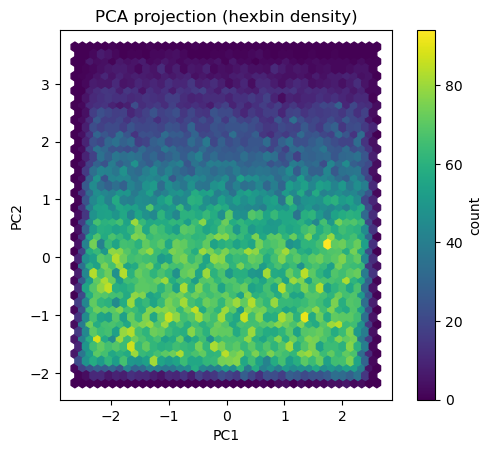

In [21]:
# ensure float array
X = x.to_numpy(dtype=float) if hasattr(x, "to_numpy") else np.asarray(x, dtype=float)

# center/scale for PCA
X_scaled = StandardScaler().fit_transform(X)
scores = PCA(n_components=2).fit_transform(X_scaled)

# compute per-axis minimal step to set a sensible jitter scale
def min_step(arr):
    u = np.unique(arr)
    return np.min(np.diff(u)) if u.size > 1 else 0.0

s0 = min_step(scores[:, 0]); s1 = min_step(scores[:, 1])
eps0 = 0.2 * (s0 if s0 > 0 else 1e-3)
eps1 = 0.2 * (s1 if s1 > 0 else 1e-3)

rng = np.random.default_rng(42)
scores_j = scores + rng.normal(scale=[eps0, eps1], size=scores.shape)

plt.figure()
plt.hexbin(scores[:, 0], scores[:, 1], gridsize=40)
plt.colorbar(label="count")
plt.gca().set(aspect="equal", title="PCA projection (hexbin density)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


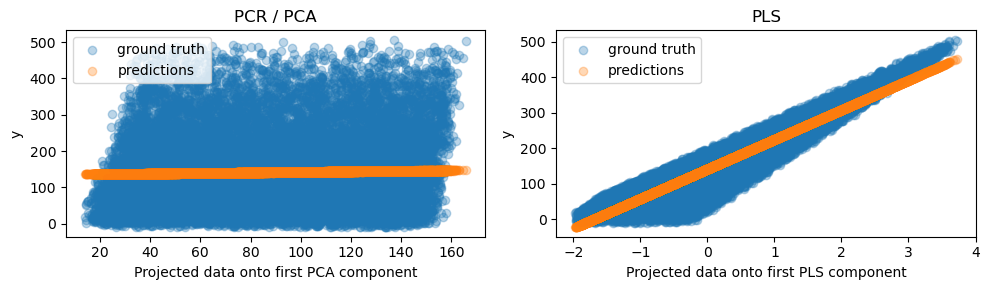

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
print("Explained variance:", pca.explained_variance_ratio_)
print("Cumulative:", np.cumsum(pca.explained_variance_ratio_))

Explained variance: [0.18129883]
Cumulative: [0.18129883]


In [24]:
pca.components_

array([[ 0.00377937, -0.00251888,  0.02771544,  0.0186284 ,  0.00491557,
         0.70662446,  0.0058938 , -0.01171753, -0.00093116,  0.70662575,
         0.00539106]])

In [ ]:
# plt.figure(figsize=(8,6))
# plt.scatter(x_pre_pca[:, 0], x_pre_pca[:, 1], c=y_pca, cmap='coolwarm', edgecolor='k')
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")
# plt.title("Original Data (First Two Features)")
# plt.colorbar(label="Demand")
# plt.show()

# plt.figure(figsize=(8,6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pca, cmap='coolwarm', edgecolor='k')
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.title("PCA Transformed Data")
# plt.colorbar(label="Demand")
# plt.show()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_pca, y_pca, test_size=0.2)

In [ ]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)

# y_pred = lr.predict(X_test)

In [ ]:
# def create_pie(y_pred, y_test, margin):
#   scores = [1 if abs(pred - test) <= margin else 0 for pred, test in zip(y_pred, y_test)]

#   scores_tuple = (scores.count(0), scores.count(1))
#   plt.figure(figsize=(8,6))
#   plt.pie(scores_tuple, labels=('0', '1'))
#   plt.title(f"Predictions within {margin} of actual demand")
#   plt.legend(labels=[f'Not within {margin}: {scores_tuple[0]}', f'Within {margin}: {scores_tuple[1]}'])

#   plt.show()

In [ ]:
# create_pie(y_pred, y_test, 40)